<a href="https://colab.research.google.com/github/Akshiti24/Images/blob/main/InpaintFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing Libs**

Diffusers, transformers, accelerate, safetensors, torch, torchvision, torchaudio are the libraries which include the pre-trained models and optimization tools particularly for NLP and Computer Vision tasks.

In [1]:
!pip install -qU diffusers transformers accelerate safetensors opencv-python torch torchvision torchaudio diffusers
!pip install -qU git+https://github.com/facebookresearch/segment-anything
!pip install -qU opencv-python-headless
!pip install -qU huggingface_hub
!pip install -qU git+https://github.com/sberbank-ai/Real-ESRGAN.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# **Download Masking Model Weights In `pth` (PyTorch Format)**

In [2]:
!wget -O maskingWeights.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-10-03 08:35:39--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.102, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘maskingWeights.pth’

maskingWeights.pth  100%[===================>]   2.39G   218MB/s    in 19s     

2024-10-03 08:35:58 (132 MB/s) - ‘maskingWeights.pth’ saved [2564550879/2564550879]



wget command is used to download a pre-trained model file named maskingWeights.pth from the public repository of Facebook AI.

The model is designed specifically for the SAM (Segment Anything Model) with the Vision Transformer (ViT) architecture and is specifically for image segmentation tasks.

.pth file contain the weights from the model, that are necessary for loading the model and running it on tasks such as object masking and segmentation.

#cloning the example images provided in the assignment

In [3]:
!git clone https://github.com/Akshiti24/Images.git

Cloning into 'Images'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 21 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 182.64 KiB | 15.22 MiB/s, done.
Resolving deltas: 100% (6/6), done.


# **Import Libs**

In [4]:
import os
import shutil
import time
import torch as th
import numpy as np
from google.colab import files
from PIL import Image
import random
from torchvision import models, transforms
import cv2
import base64
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from diffusers import AutoPipelineForInpainting, DEISMultistepScheduler, StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
import IPython.display as iPython
import requests
from RealESRGAN import RealESRGAN
from IPython.display import Video
import urllib.request

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/RealESRGAN/model.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast()


* Diffusers is a Python library from Hugging Face designed to work with generative models. Diffusion models generate data by iteratively refining noise into structured data, such as images. The library supports various tasks like image generation, inpainting, text-to-image generation, etc.

* AutoPipelineForInpainting is a class in the diffusers library that provides a pre-configured pipeline for inpainting tasks (filling in missing or corrupted parts of an image in a way that looks natural).

* The DEIS (Denoising Implicit Sampler) is an efficient sampling strategy which improves the model's performance.

  DEISMultistepScheduler is a scheduler in the diffusers library which controls the timestep scheduling of the denoising process in a diffusion model.

* load_image is a utility function that loads an image from a given file path or URL into a format that can be processed by the models and are compatible with the model inputs.

* RealESRGAN -> Real-World Enhanced Super-Resolution Generative Adversarial Networks.

  This advance model inceases the resolution of images while preserving or enhnacing the quality.

# **Download Input Image with White Background**

This piece of code allow users to provide the input image in three ways:

(1) by entering a URL to download an image,

(2) by picking an image from a folder (/content/Images), or

(3) by uploading an image from their device.

It shows the available images in the folder and displays the selected image using the PIL library.

In [5]:
REPO_IMAGES = "/content/Images"

def list_images_in_repo():
    images = [f for f in os.listdir(REPO_IMAGES) if f.endswith(('png', 'jpg', 'jpeg', 'gif', 'webp'))]
    if images:
        print("Images available in the repository:")
        for i, image in enumerate(images):
            print(f"{i+1}. {image}")
        return images
    else:
        print("No images found in the repository.")
        return []

def user_input_image():
    inputPath = None

    print("Select an option to provide the image:")
    print("1. Image URL")
    print("2. Choose an image from the repository")
    print("3. Upload an image")

    option = input("Enter option number (1/2/3): ")

    if option == '1':
        url = input("Enter the image URL: ")
        output_filename = "downloaded_input_image.jpg"
        try:
            urllib.request.urlretrieve(url, output_filename)
            img = Image.open(output_filename)
            img.show()
            inputPath = output_filename
        except:
            print("Failed to load image from URL.")

    elif option == '2':
        images = list_images_in_repo()
        if images:
            image_choice = int(input("Enter the number corresponding to the image: ")) - 1
            if 0 <= image_choice < len(images):
                chosen_image_path = os.path.join(REPO_IMAGES, images[image_choice])
                img = Image.open(chosen_image_path)
                img.show()
                inputPath = chosen_image_path
            else:
                print("Invalid choice.")

    elif option == '3':
        from google.colab import files
        uploaded = files.upload()
        if uploaded:
            filename = next(iter(uploaded))
            img = Image.open(filename)
            img.show()
            inputPath = filename
        else:
            print("No file uploaded.")
    else:
        print("Invalid option.")

    return inputPath

inputPath = user_input_image()

Select an option to provide the image:
1. Image URL
2. Choose an image from the repository
3. Upload an image
Enter option number (1/2/3): 2
Images available in the repository:
1. office_chair.jpg
2. cycle.jpg
3. Cooker.jpg
4. Toaster.jpg
Enter the number corresponding to the image: 3


**Function to Display Image In Jupyter Notebook**

In [6]:
def displayImage(path: str) -> None:
    iPython.display(iPython.Image(filename=path))

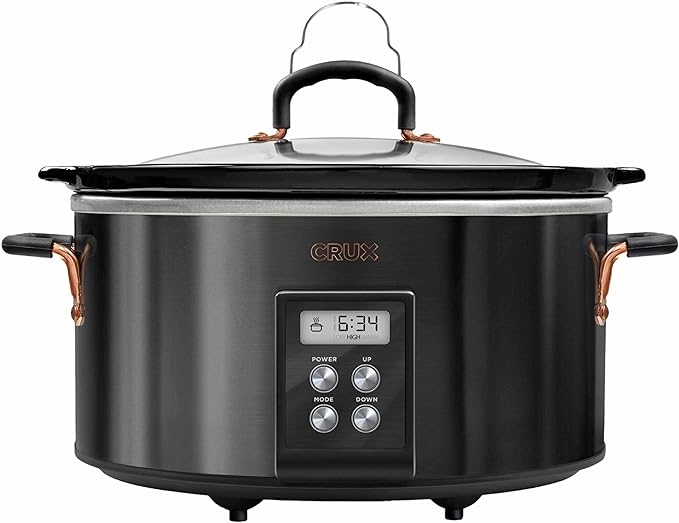

In [7]:
displayImage(inputPath)

**Function to Make Mask Images**

In [8]:
def createObjectMaskSAM(inputPath: str, generatedPath: str, sam_checkpoint: str) -> str:
    input_image = cv2.imread(inputPath)
    sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
    sam.to(device="cuda")

    mask_generator = SamAutomaticMaskGenerator(sam)

    masks = mask_generator.generate(input_image)

    object_mask = masks[0]['segmentation']

    mask_image = (object_mask.astype(np.uint8) * 255)


    h, w = mask_image.shape
    center_region = mask_image[h//4: 3*h//4, w//4: 3*w//4]
    center_mean = np.mean(center_region)

    if center_mean > 127:
        mask_image = cv2.bitwise_not(mask_image)

    kernel = np.ones((3,3),np.uint8)
    mask_image = cv2.morphologyEx(mask_image, cv2.MORPH_CLOSE, kernel)

    cv2.imwrite(generatedPath, mask_image)

    return os.getcwd() + "/" + generatedPath

This function takes an image, processes it to find the main object, creates a mask for that object, and saves the mask image to a specified location.

* It initializes the SAM model, moves the model to the GPU.

* It creates an instance of the mask generator which will be used to create masks for objects in the input image and generates mask for the input image.

* It converts the object mask to an 8-bit unsigned integer format (which is suitable for image representation) and scales the values by multiplying by 255. This creates a binary mask where the segmented area has a value of 255 (white) and the background has a value of 0 (black).

* It inverts the mask image using OpenCV’s bitwise_not function. This flips the colors, so the segmented area becomes black (0) and the background becomes white (255).

* And saves the processed mask image.  

**Generated Mask of Image**

In [9]:
maskImagePath = createObjectMaskSAM(inputPath, r"maskImg.jpg", r"/content/maskingWeights.pth")

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


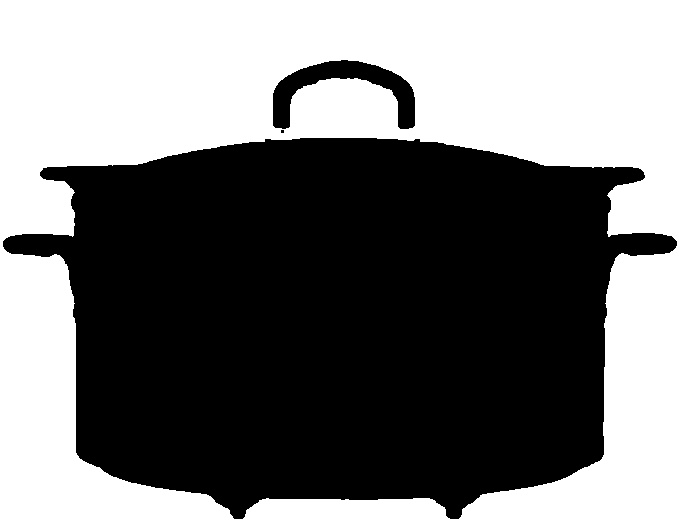

In [10]:
displayImage(maskImagePath)

**Calculate Random Seed**

In [11]:
used_seed = random.randint(0, 1000)
print("Seed Being Used", used_seed)
generator = th.manual_seed(used_seed)

Seed Being Used 741


This code generates a random seed and then sets this seed in PyTorch to ensure consistent results (Using the same seed will produce the same results across different runs).

**Load Images (Input Image & Mask Image)**

In [12]:
image = load_image(inputPath)
mask_image = load_image(maskImagePath)

**Defining Prompts**

Taking the prompt from the user to create a realistic and coherent image combind with the background.

In [13]:
prompt = input("Enter the prompt: ")
prompt = prompt + " make it {{realistic}} and {{focus on good lighting}}, {{{make it coherent and highly great}}}"
negPrompt = "{{unrealistic}} {{bad}} {{ugly}} {{worst}}"

Enter the prompt: Object placed in the kitchen


* Things written in multiple curly braces{} means more and special importance given to those phrases.

* negative prompt is used to describe how the generated image should not be.

**Load Pipeline for Inpainting Model**

In [14]:
pipe = AutoPipelineForInpainting.from_pretrained('Lykon/dreamshaper-8-inpainting', torch_dtype=th.float16, variant="fp16")
pipe.scheduler = DEISMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/767 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


* This piece of code initializes a pre-trained inpainting model named 'dreamshaper-8-inpainting' from the Hugging Face model hub, setting the data type to half-precision (float16) for efficient computation.

* Inpainting pipeline's scheduler is configured using the DEISMultistepScheduler.

* The pipeline is transferred to the GPU (cuda) for faster processing.

---

Other alternatives for accomplishing tasks like this are:

*   Stable Diffusion - An open-source model that can generate images from text prompts and supports inpainting.

* DALL-E 2 - OpenAI model for image generation that can also perform inpainting by editing images based on textual prompts.

* DeepAI Image Inpainting API - An API that provides inpainting capabilities using deep learning models.

* Inpainting with Generative Adversarial Networks (GANs) -  Models like Pix2Pix or Context Encoders utilize GANs for inpainting tasks.

Benefits that 'dreamshaper-8-inpainting' model which I used here has over other alternatives are:

* The model is specifically fine-tuned for inpainting tasks, which may not be the case for general-purpose models like DALL-E 2 or Stable Diffusion.

* The inclusion of the DEISMultistepScheduler is specifically tailored for enhancing the inpainting process, potentially leading to better results compared to models that use standard scheduling methods.

* Simplified Pipeline Setup: The use of AutoPipelineForInpainting offers a streamlined approach for deploying inpainting without needing extensive configuration, which is not always available in other models.









**Generate Image**

In [15]:
madeImage = pipe(prompt, negative_prompt=negPrompt, image=image, mask_image=mask_image, generator=generator, num_inference_steps=250).images[0]

  0%|          | 0/250 [00:00<?, ?it/s]

This line of code generates an inpainted image based on the provided prompt, negative prompt, original image, mask image, and a random seed, while allowing for a specified number of inference steps to control the quality of the output.

**Save Generated Image**

Creates a complete file path in the current working directory.

And saves the image.

In [16]:
madeImagePath = os.getcwd() + "/madeImageByModel.png"

In [17]:
madeImage.save(madeImagePath)

**Display Made Up Image**

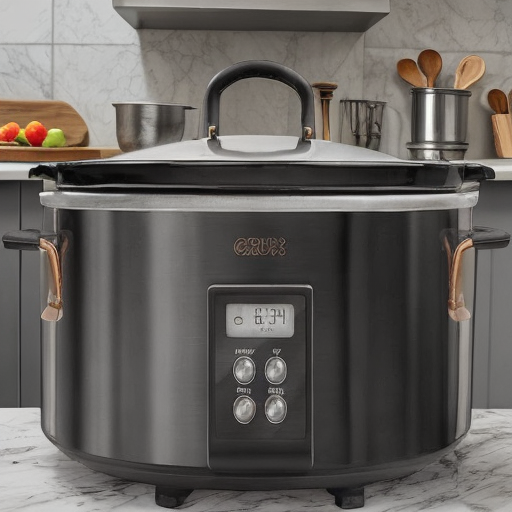

In [18]:
displayImage(madeImagePath)

#### **Function to Enhance Image**

In [19]:
def enhanceImage(input_path, output_path):
    img = cv2.imread(input_path)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    cv2.imwrite(output_path, enhanced_img)
    return os.getcwd() + "/" + output_path

In [20]:
enhancedImagePath = enhanceImage(madeImagePath, "enhancedImage.png")

* This function improves the contrast of an image using Contrast Limited Adaptive Histogram Equalization (CLAHE).

* The image is converted from the BGR color space to the LAB color space, which separates lightness from color, helping in enhancing the image without affecting its colors.

* CLAHE improves contrast by adjusting lightness in small areas of the image. It helps make details clearer, especially in images with uneven lighting.

* The function enhances the lightness and combines it back with the original color information (A and B channels) and converts the image back to the BGR color space.

* The image is then saved and the function return the full path of the enhanced image.



**Display Enhanced Image**

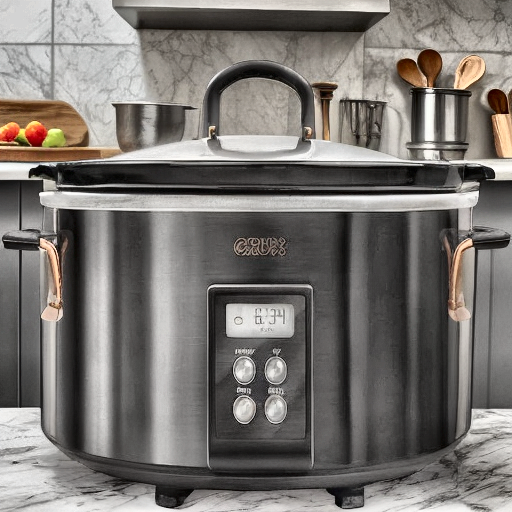

In [21]:
displayImage(enhancedImagePath)

#### **Convert Image To Super Resolution Using SRGAN**

In [22]:
modelSR = RealESRGAN(th.device('cuda' if th.cuda.is_available() else 'cpu'), scale=4)
modelSR.load_weights('weights/RealESRGAN_x4.pth', download=True)
sr_image = modelSR.predict(Image.open(enhancedImagePath).convert('RGB'))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:672: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


RealESRGAN_x4.pth:   0%|          | 0.00/67.0M [00:00<?, ?B/s]

Weights downloaded to: weights/RealESRGAN_x4.pth


/usr/local/lib/python3.10/dist-packages/RealESRGAN/model.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loadnet = torch.load(model_path)


* ESRGAN (Enhanced Super Resolution Generative Adversarial Network) is a deep learning model used for image super-resolution, which is the process of enhancing the resolution of images. Specifically, ESRGAN aims to generate high-resolution images from low-resolution inputs by predicting and filling in details that may be missing.

* This code takes an already enhanced image and applies the ESRGAN model to it to produce a higher-resolution version of that image.

In [23]:
finalPath = os.getcwd() + "/finalImage.png"

In [24]:
sr_image.save(finalPath)

**Display Image Final Image**

__Note:__ It will take time to load depending upon your internet speed as it's very high resolution

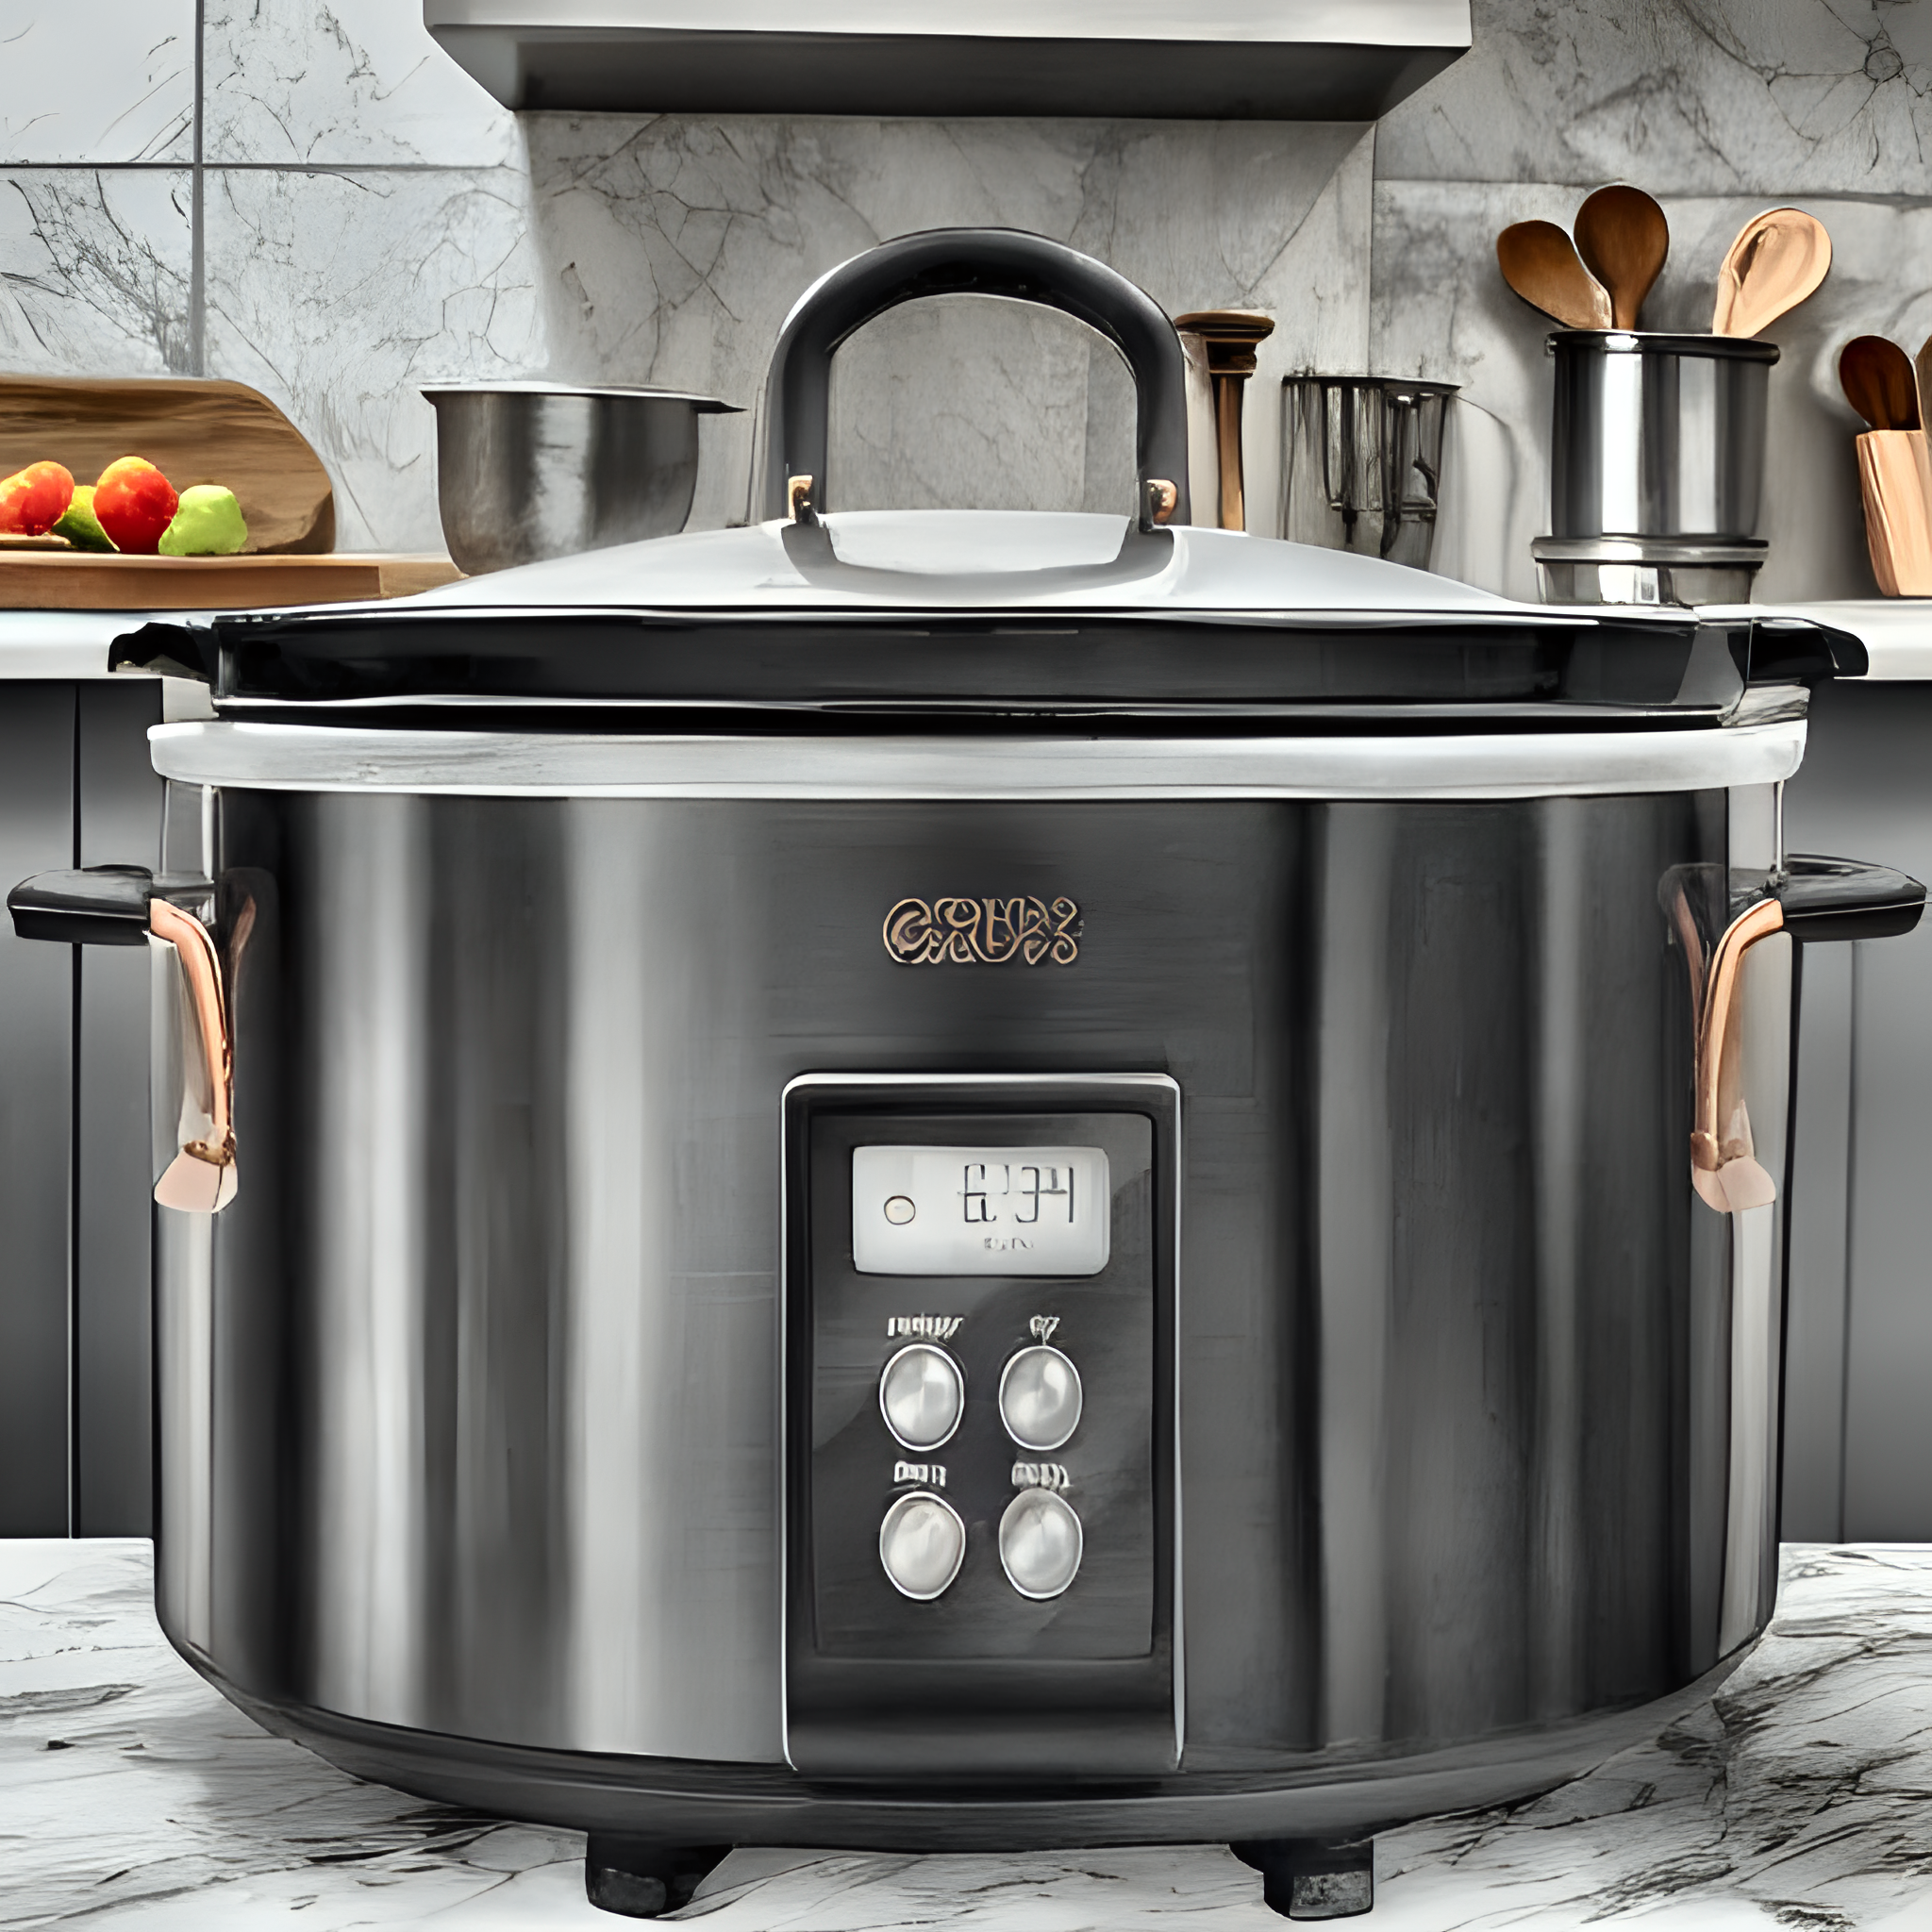

In [25]:
displayImage(finalPath)

# Creating a small video output

Use stable diffusion img2vid model



In [26]:
pipeline = StableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=th.float16, variant="fp16"
)
pipeline.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/496 [00:00<?, ?B/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/3.05G [00:00<?, ?B/s]

image_encoder/config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/196M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/984 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Load Image and Resize It

In [27]:
image = load_image(finalPath)
image = image.resize((1024, 576))

Generate New Seed Using Torch

In [28]:
generator = th.manual_seed(42)

Generate Video

In [29]:
frames = pipeline(image, decode_chunk_size=8, generator=generator).frames[0]

  0%|          | 0/25 [00:00<?, ?it/s]

Export the video


In [30]:
outputVideoPath = os.getcwd() + "/" + "generated.mp4"

In [31]:
export_to_video(frames, outputVideoPath, fps=7)

'/content/generated.mp4'

In [32]:
Video(outputVideoPath, embed=True, width=600, height=400)